In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import os,datetime
import locale
from IPython.display import HTML
locale.setlocale(locale.LC_ALL, '')

'LC_CTYPE=pt_BR.UTF-8;LC_NUMERIC=pt_BR.UTF-8;LC_TIME=pt_BR.UTF-8;LC_COLLATE=en_US.UTF-8;LC_MONETARY=pt_BR.UTF-8;LC_MESSAGES=en_US.UTF-8;LC_PAPER=pt_BR.UTF-8;LC_NAME=pt_BR.UTF-8;LC_ADDRESS=pt_BR.UTF-8;LC_TELEPHONE=pt_BR.UTF-8;LC_MEASUREMENT=pt_BR.UTF-8;LC_IDENTIFICATION=pt_BR.UTF-8'

In [2]:
user = os.environ.get('USER_DB_NTFCE')
host = 'localhost'
#        host = '192.168.15.8'
password = os.environ.get('PASS_DB_NTFCE')
banco = 'nota_fiscal'
sql = 'select * from nota_fiscal_produtos_v'
engine = create_engine('mysql://{}:{}@{}/{}'.format(user,password,host, banco), 
                                                    echo = False,
                                                    isolation_level="READ COMMITTED")
conexao = engine.connect()

compras_result_proxy = conexao.execute(sql)
compras_db = compras_result_proxy.fetchall()

#display(compras_result_proxy.keys()) #mostra as colunas
#display(compras_db)

df_compras = pd.DataFrame(compras_db,
                          columns =compras_result_proxy.keys())

df_compras.vl_prod_serv = df_compras.vl_prod_serv.astype(float)
df_compras.vl_pago = df_compras.vl_pago.astype(float)
df_compras.vl_desconto_prod_serv = df_compras.vl_desconto_prod_serv.astype(float)

df_compras['mes_ano_emissao'] =  df_compras.dt_emissao.dt.to_period('M')
#df_compras.columns = compras_result_proxy.keys() #coloca os nomes das colunas
# df_compras.dt_emissao.dt.year
#df_compras.head()
#df_compras.dtypes



In [34]:


def formatar_float(x,decimal=False):
    if decimal:
        return f'{locale.format_string("%.2f", x, True)}'
    else:
        return f'{locale.format_string("%.0f", x, True)}'

ultimos_anos = []
anos = df_compras.dt_emissao.dt.year.unique()
for ano in anos:
    if ano > datetime.datetime.now().year - 3: #pega os ultimos três anos da base, a partir do ano atual
        ultimos_anos.append(ano)




,Mês Ano,Valor
1,2020-02,"304,17"
2,2020-03,"2.553,84"
3,2020-04,"1.710,34"
4,2020-05,"2.717,73"
5,2020-06,"2.274,75"
6,2020-07,"2.914,46"
7,2020-08,"1.346,61"
8,2020-09,"3.515,11"
9,2020-10,"860,51"


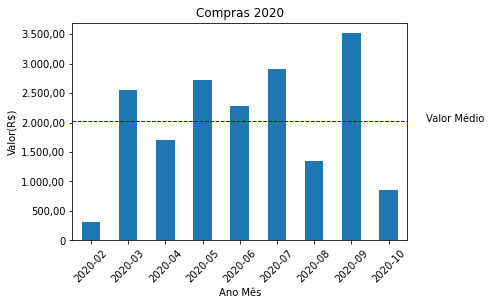

In [35]:
#Valor total mensal das compras por ano


fig, ax = plt.subplots()

for ano in ultimos_anos:
    df_compras_anual = df_compras[df_compras.dt_emissao.dt.year == ano]
    
    df_compras_anual = pd.DataFrame(df_compras_anual.groupby(df_compras_anual['mes_ano_emissao'])['vl_pago'].agg('sum'))

    valor_medio = round(df_compras_anual.vl_pago.mean(),2)
    pos_ultimo_mes = df_compras_anual.shape[0]
    df_compras_anual.plot(kind='bar',y='vl_pago',ax=ax)
    formatter = FuncFormatter(formatar_float)
    ax.yaxis.set_major_formatter(formatter)
    ax.legend().set_visible(False)
    ax.set(title=f'Compras {ano}', xlabel='Ano Mês', ylabel='Valor(R$)')
    ax.axhline(y=valor_medio, color='b', label='Valor Médio', linestyle='--', linewidth=1)
    ax.text(pos_ultimo_mes, valor_medio, "Valor Médio")
#     ax.xticks(rotation=90)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    
    df_compras_anual = df_compras_anual.reset_index()
    df_compras_anual.index += 1
    df_compras_anual.columns = ['Mês Ano','Valor']
    estilo = {'Valor': lambda x: f'{locale.format_string("%.2f", x, True)}'}
    df_style = df_compras_anual.style.format(estilo) #.style.hide_index()
    display(HTML(f'<h3> Valor Total - Compras Mensais - {ano} </h3>'))
    
    display(df_style.background_gradient(cmap='Blues'))
    

,mes_ano_emissao,cnpj,estabelecimento,vl_pago
0,2020-02,04917916000161,LG FORTES EIRELI - ME,55.82
1,2020-02,34274233001508,PETROBRASDISTRIBUIDORASA,188.55
2,2020-02,61412110043474,DROGARIA SAO PAULO SA,15.48
3,2020-02,61585865183485,RAIADROGASIL S.A.,44.32
4,2020-03,00063960004864,WMB SUPERMERCADOS DO BRASIL LTDA.,615.01
...,...,...,...,...
77,2020-10,13237300000211,LIMIAR IND E COM DE ALIM LTDA,7.50
78,2020-10,15507356000193,R R INDUSTRIACOMERCIO PANIFICACAO LTDA,22.42
79,2020-10,26269014000107,DELI FRUTA COMERCIAL DE ALIMENTOS EIRELI,38.47
80,2020-10,39346861007840,CENCOSUD BRASIL COMERCIAL LTDA,149.46


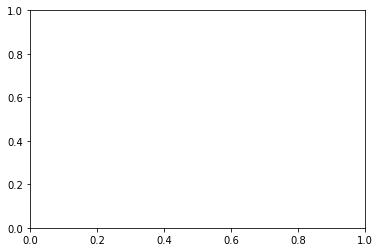

In [46]:
#Valor total mensal por empresa das compras por ano

fig, ax = plt.subplots()

for ano in ultimos_anos:
    df_compras_anual = df_compras[df_compras.dt_emissao.dt.year == ano]
    
    df_compras_anual = pd.DataFrame(df_compras_anual.groupby(['mes_ano_emissao','cnpj','estabelecimento'])['vl_pago'].agg('sum'))
    df_compras_anual = df_compras_anual.reset_index()
    valor_medio = round(df_compras_anual.vl_pago.mean(),2)
    
    pos_ultimo_mes = df_compras_anual.mes_ano_emissao.dt.month.unique().shape[0]
    display(df_compras_anual)
#     df_compras_anual.plot(kind='bar',y='vl_pago',ax=ax)
#     formatter = FuncFormatter(formatar_float)
#     ax.yaxis.set_major_formatter(formatter)
#     ax.legend().set_visible(False)
#     ax.set(title=f'Compras {ano}', xlabel='Ano Mês', ylabel='Valor(R$)')
#     ax.axhline(y=valor_medio, color='b', label='Valor Médio', linestyle='--', linewidth=1)
#     ax.text(pos_ultimo_mes, valor_medio, "Valor Médio")
#     ax.xticks(rotation=90)
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(45)

    
#     df_compras_anual = df_compras_anual.reset_index()
#     df_compras_anual.index += 1
#     df_compras_anual.columns = ['Mês Ano','Valor']
#     estilo = {'Valor': lambda x: f'{locale.format_string("%.2f", x, True)}'}
#     df_style = df_compras_anual.style.format(estilo) #.style.hide_index()
#     display(HTML(f'<h3> Valor Total - Compras Mensais - {ano} </h3>'))
    
#     display(df_style.background_gradient(cmap='Blues'))